# Recurrent Neural Network - LSTM


## Part 1 - Data Preprocessing

---



### Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
#from lifelines.utils import concordance_index

from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras import regularizers 
from keras import backend as tf

import keras.backend as K
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *


import sys, time, random, json, pickle, itertools
import networkx as nx
import matplotlib
import scipy.stats
from sklearn.neighbors import KernelDensity
import statsmodels.stats.correlation_tools as stm
from scipy.stats import norm

import torch, torchvision
from sklearn.preprocessing import MinMaxScaler
np.random.seed(12345678)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import the database

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os
workdir_path = '/content/drive/MyDrive/Summer 2022 RA'
os.chdir(workdir_path)

Mounted at /content/drive


In [3]:
# Define data files
datadir = 'dataverse_files/'
datafn_tmpl = datadir + 'sms-call-internet-mi-%4d-%02d-%02d.txt'
datafn_idxs = [ (2013, 11, i) for i in range(1,15) ]  #+ [ (2013, 12, i) for i in range(1, 32) ] + [ (2014, 1, 1) ]
datafns = [ datafn_tmpl % x for x in datafn_idxs ]
print("Number of non-existent files:", sum([ not os.path.exists(fn) for fn in datafns ]))
outfn = datadir[:-1] + '-internet.csv'

# dataset_train = pd.read_csv('train.csv')
# training_set = dataset_train.iloc[:, 1:2].values #only column of the series itself

Number of non-existent files: 0


In [4]:
# Pick the data files to index
fns = datafns#[:10]

### Read and Preprocess Data (Save to CSV)

In [5]:
data = pd.DataFrame()
for fn in fns:
    #print('Reading file ', fn, ' ...')
    df = pd.read_csv(fn, sep="\t", header=None, names=['grid', 'time', 'country', 'sms-in', 'sms-out', 'call-in', 'call-out', 'internet'])
    df = df[ df['country'] == 39 ].drop(columns=['country', 'sms-in', 'sms-out', 'call-in', 'call-out']).fillna(0)
    data = pd.concat([ data, df ])
data = data.sort_values(by=['time', 'grid']).reset_index(drop=True)

In [6]:
# Statistics of the dataset
print("# 10min slots:", len(data['time'].unique()) )
print("Mean internet:", data['internet'].mean())
print("(Min, 5%, 25%, median, 75%, 95%, max) internet:")
print( ( data['internet'].min(), data['internet'].quantile(0.05), data['internet'].quantile(0.25), data['internet'].median(), data['internet'].quantile(0.75), data['internet'].quantile(0.95), data['internet'].max() )  )

# 10min slots: 2016
Mean internet: 70.20679242677677
(Min, 5%, 25%, median, 75%, 95%, max) internet:
(0.0, 3.1835907387006883, 11.816370411143543, 30.41234899954803, 71.04352514522425, 272.3307009563439, 7936.265379884158)


In [7]:
data.to_csv(outfn)

### Load Data

In [8]:
data = pd.read_csv(outfn, index_col=0)
print("# 10min slots:", len(data['time'].unique()) )

# 10min slots: 2016


In [9]:
# Find a grid with the maximum total demand for the prediction task
max_dmd_grid = sorted([ ( data[ data['grid']==i ]['internet'].sum(), i ) for i in range(1, 10001) ])
max_dmd_grid = list(reversed(max_dmd_grid))
gridx = max_dmd_grid[0][1]
#max_dmd_grid[:30]

In [10]:
datax = data[ data['grid'] == gridx ].reset_index(drop=True)

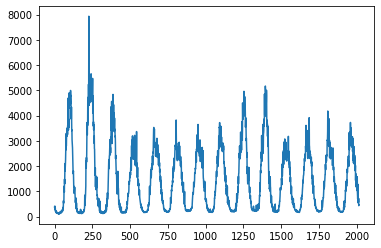

In [11]:
# Plot the data
datax['internet'].plot()

### Learning and Prediction

### Preparing data

In [12]:
# Parameters
total_size = len(datax.index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 1344 Test size: 672


In [13]:
# Train/test split
#x = datax['internet'].to_numpy()

train = datax[:train_size]
test = datax[train_size:]
dataset_train = train
training_set = dataset_train.iloc[:, 2:3].values

### Time Series Graph

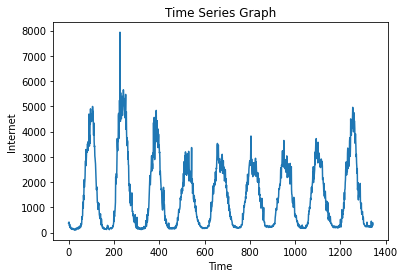

In [14]:
plt.plot(training_set)
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Graph")
plt.show()

# plt.plot(datax['internet'])
# plt.xlabel("Time")
# plt.ylabel("Internet")
# plt.title("Time Series Graph")
# plt.show()

### Normalization



In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Create the data structure with window 15 and output 1

In [16]:
window = 144
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [17]:
X_train.shape

(1200, 144)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
X_train.shape

(1200, 144, 1)

## Part 2 - Construction of the RNN

### Construction of the complete network

In [20]:
# Initialize the RNN
regressor = Sequential()

# Add the first LSTM layer and Dropout 
regressor.add(GRU(units = len(train), return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Add the second LSTM layer and Dropout
regressor.add(GRU(units = window, return_sequences = False))
regressor.add(Dropout(0.2))
 
# # Add the third LSTM layer and Dropout
# regressor.add(LSTM(units = 50, return_sequences = False))
# regressor.add(Dropout(0.2))
 
# Output layer
regressor.add(Dense(units = 1))
 
# Compile the network
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Summarize the network
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 144, 1344)         5431104   
                                                                 
 dropout (Dropout)           (None, 144, 1344)         0         
                                                                 
 gru_1 (GRU)                 (None, 144)               643680    
                                                                 
 dropout_1 (Dropout)         (None, 144)               0         
                                                                 
 dense (Dense)               (None, 1)                 145       
                                                                 
Total params: 6,074,929
Trainable params: 6,074,929
Non-trainable params: 0
_________________________________________________________________


### Training

In [21]:
regressor.fit(X_train, y_train, epochs = 150, batch_size = 128)

Epoch 1/150
10/10 [==============================] - 9s 198ms/step - loss: 0.0128
Epoch 2/150
10/10 [==============================] - 2s 198ms/step - loss: 0.0023
Epoch 3/150
10/10 [==============================] - 2s 199ms/step - loss: 0.0016
Epoch 4/150
10/10 [==============================] - 2s 200ms/step - loss: 0.0016
Epoch 5/150
10/10 [==============================] - 2s 199ms/step - loss: 0.0014
Epoch 6/150
10/10 [==============================] - 2s 201ms/step - loss: 0.0014
Epoch 7/150
10/10 [==============================] - 2s 200ms/step - loss: 0.0013
Epoch 8/150
10/10 [==============================] - 2s 200ms/step - loss: 0.0014
Epoch 9/150
10/10 [==============================] - 2s 200ms/step - loss: 0.0015
Epoch 10/150
10/10 [==============================] - 2s 200ms/step - loss: 0.0014
Epoch 11/150
10/10 [==============================] - 2s 201ms/step - loss: 0.0015
Epoch 12/150
10/10 [==============================] - 2s 201ms/step - loss: 0.0015
Epoch 13/150


## Part 3 - Making predictions and analyzing the results

### Test base

In [22]:
dataset_test = test
test_pul = dataset_test.iloc[:, 2:3].values

### Build the framework for testing

In [23]:
dataset_total = pd.concat((dataset_train.iloc[:,2], dataset_test.iloc[:,2]), axis = 0)

testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Make the predictions


In [24]:
predicted = regressor.predict(X_test)
regressor.save_weights('weightsfile_gru.h5')
#existingModel.load_weights('weightsfile.h5')
predicted = sc.inverse_transform(predicted)

In [25]:
# print(len(predictions))
# print(predictions.shape)

In [26]:
# x = np.arange(test_size)

### Visualization of training and test results

In [27]:
# plt.title('Time slot vs mobile traffic')
# plt.ylabel('Internet traffic')
# plt.grid(True)
# plt.autoscale(axis='x', tight=True)
# plt.plot(test)
# plt.plot(x,predictions)
# plt.show()

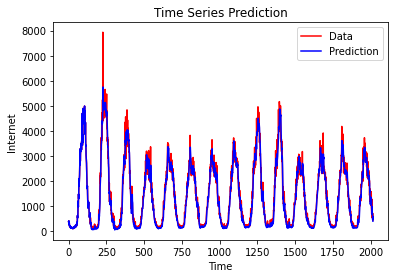

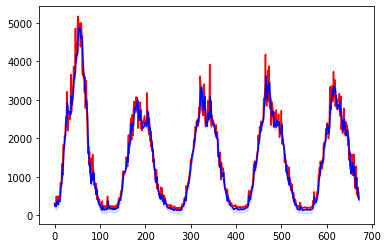

In [28]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Data')
plt.plot(allForecastedData, color = 'blue', label = 'Prediction')
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Prediction")
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

from matplotlib import pyplot as plt
import numpy as np

#some example data
x = np.arange(test_size)
# plt.title('Time slot vs mobile traffic')
# plt.ylabel('Internet traffic')
# plt.grid(True)
# plt.autoscale(axis='x', tight=True)
# plt.plot(test)
# plt.plot(x,predictions)
# plt.show()
y = predicted.reshape(-1,)
#some confidence interval
ci = 1.96 * np.std(predicted)/np.sqrt(len(x))

fig, ax = plt.subplots()
ax.plot(x,test_pul.reshape(-1,),'r')
ax.plot(x,y, 'b')
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

## Part 4 - Evaluation Metrics


In [29]:
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  240.84081711124708


In [30]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  58004.299186813165


In [31]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  15.86046469243621 %


In [32]:
mae = mean_absolute_error(test_pul, predicted)
print('MAE: ',mae)

MAE:  164.61025801279695


### Statistics of the test results.

Using the mean (predicted)

In [33]:
# Fraction of under-estimated demands using the mean (predicted)
violated = (predicted < test_pul)
violations = (test_pul - predicted)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: [455] (67.71% of the test data points)


In [34]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations ) / np.mean(test_pul)) )

Demand mean: 1477.7230073152343
Violation mean: 160.27450852502574
Violation excess: 10.85%


Using higher 95% confidence interval

In [35]:
ninety_fine_ci_higher = (y+ci).reshape(-1,1)
# Fraction of under-estimated demands using higher 95% confidence interval
violated_higher = (ninety_fine_ci_higher < test_pul)
violations_higher = (test_pul - ninety_fine_ci_higher)[violated_higher]
print('Total violations:', sum(violated_higher), '(%.2f%% of the test data points)' % (100*sum(violated_higher)/test_size) )

Total violations: [233] (34.67% of the test data points)


In [36]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations_higher ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations_higher) / np.mean(test_pul)) )

Demand mean: 1477.7230073152343
Violation mean: 178.54985148462083
Violation excess: 12.08%


Using lower 95% confidence interval

In [37]:
ninety_fine_ci_lower = (y-ci).reshape(-1,1)
# Fraction of under-estimated demands using higher 95% confidence interval
violated_lower = (ninety_fine_ci_lower < test_pul)
violations_lower = (test_pul - ninety_fine_ci_lower)[violated_lower]
print('Total violations:', sum(violated_lower), '(%.2f%% of the test data points)' % (100*sum(violated_lower)/test_size) )

Total violations: [548] (81.55% of the test data points)


In [38]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations_lower ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations_lower) / np.mean(test_pul)) )

Demand mean: 1477.7230073152343
Violation mean: 214.82445401445366
Violation excess: 14.54%


In [39]:
# from scipy import stats
# from scipy.stats import norm

In [40]:
# ci = stats.norm.interval(0.95,np.mean(predicted),np.std(predicted)/(1738**0.5))
# print('95% CI is:',np.round(beml_ci,6))